# STILL NONSENSE TESTING - IGNORE 

In [1]:
%load_ext autoreload
%autoreload 2
from scipy import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from braincoder.utils.visualize import *
%matplotlib inline

In [2]:
import bayesflow

/Users/marcusdaghlian/miniforge3/envs/bflow/lib/python3.12/site-packages/bayesflow/trainers.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [5]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[]

(array([   8.,   63.,  401., 1339., 2709., 2834., 1836.,  667.,  123.,
          19.]),
 array([-4.01253892, -3.23507602, -2.45761311, -1.68015021, -0.90268731,
        -0.1252244 ,  0.6522385 ,  1.42970141,  2.20716431,  2.98462722,
         3.76209012]),
 <BarContainer object of 10 artists>)

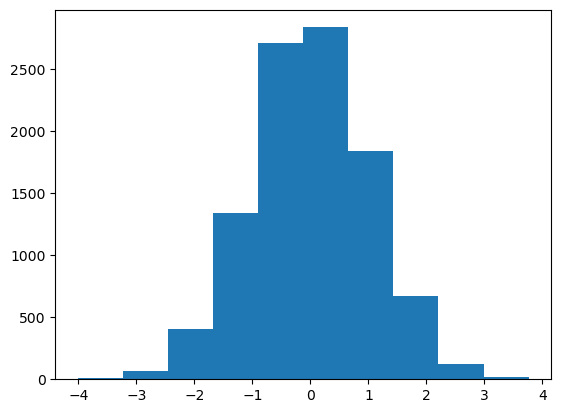

In [9]:
RNG = np.random.default_rng(2023)

# Simulate data

In [2]:
import prfpy_csenf
import os 
from os.path import join as opj
seq_path = os.path.join(os.path.dirname(prfpy_csenf.__path__[0]))
sfs_seq = np.load(opj(seq_path, 'eg_sfs_seq.npy'))

con_seq = np.load(opj(seq_path, 'eg_con_seq.npy'))
paradigm = np.vstack([sfs_seq, con_seq])


In [3]:
# Stimulus object 
from braincoder.stimuli import ContrastSensitivityStimulus
cs_stim = ContrastSensitivityStimulus()

In [4]:
bounds = {
    'width_r'  : [0,1.5],          
    'SFp'       : [0, 6],
    'CSp'       : [0, 200] ,
    'width_l'   : [0, 1.5],     # we fix width_l in our model
    'crf_exp'   : [0, 5] ,
    'amplitude' : [0, 10],       # Amplitude of TC
    'baseline'  : [-2,2]
}
n_vx = 1000
parameters = pd.DataFrame({
    key:np.random.uniform(bounds[key][0], bounds[key][1], n_vx) for key in bounds
}).astype('float32')

n_vx = parameters.shape[0]
idx_cols = sns.color_palette("hsv", n_vx)

In [5]:
from braincoder.models import ContrastSensitivity, ContrastSensitivityWithHRF
from braincoder.hrf import SPMHRFModel, CustomHRFModel, HRFModel

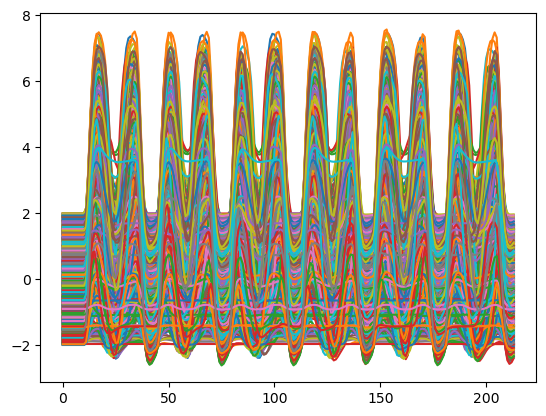

In [6]:
model = ContrastSensitivityWithHRF(
    parameters=parameters,
    SF_seq=sfs_seq,  
    CON_seq=con_seq,       
    hrf_model=SPMHRFModel(tr=1.5),

)
pred = model.predict()
plt.plot(pred)

# Classic fitter

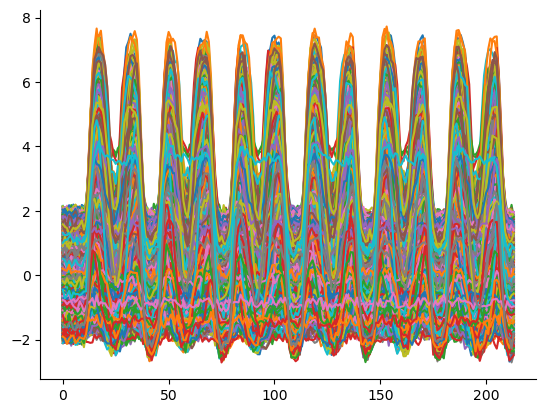

In [7]:

data = model.simulate(noise=.1)
data.plot(legend=False)
sns.despine()
    

In [8]:
from braincoder.bprf_mcmc import *
from braincoder.optimize import ParameterFitter
cfitter = ParameterFitter(model, data, model.paradigm)
grid_pars = cfitter.fit_grid(
    width_r     =np.linspace(bounds['width_r'][0], bounds['width_r'][1], 5),
    SFp         =np.linspace(bounds['SFp'][0], bounds['SFp'][1], 5),
    CSp         =np.linspace(bounds['CSp'][0], bounds['CSp'][1], 10),
    width_l     =np.linspace(bounds['width_l'][0], bounds['width_l'][1], 5),
    crf_exp     =np.linspace(bounds['crf_exp'][0], bounds['crf_exp'][1], 5),
    amplitude   =[1.0],
    baseline    =[0],
    use_correlation_cost=True
)
ols_pars = cfitter.refine_baseline_and_amplitude(grid_pars)
refined_pars = cfitter.fit(init_pars=ols_pars, ) #fixed_pars={'width_l' : 0.68})

/Users/marcusdaghlian/miniforge3/envs/braincoder/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Working with chunk size of 519
Using correlation cost!


100%|██████████| 13/13 [00:00<00:00, 20.82it/s]
/Users/marcusdaghlian/programs/braincoder_bprf/braincoder/optimize.py:420: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.60192037e+00 2.01909399e+00 3.29277563e+00 7.81076622e+00
 3.78848267e+00 1.10568643e+00 7.61896223e-02 4.27778482e+00
 3.39321256e+00 6.69169807e+00 8.06139660e+00 1.39463973e+00
 5.05826139e+00 5.49277115e+00 5.85864687e+00 2.39932871e+00
 9.52740908e-01 2.50001240e+00 4.24332201e-01 7.51804113e+00
 7.63844919e+00 1.00000000e-04 4.10147142e+00 5.05458117e+00
 1.00000000e-04 5.76922369e+00 9.89951491e-01 8.12461185e+00
 4.25824642e+00 9.18730354e+00 1.37686729e+00 6.63857400e-01
 5.35688400e+00 7.38066483e+00 2.42300525e-01 9.47086906e+00
 5.40215254e+00 6.69829416e+00 6.83293009e+00 7.41994524e+00
 7.37212944e+00 4.95618391e+00 2.29559517e+00 2.85781765e+00
 6.58592176e+00 3.69917679e+00 5.08739424e+00 1.77378154e+00
 4.94016361e+00 

Number of problematic voxels (mask): 0
Number of voxels remaining (mask): 1000


Current R2: nan/Best R2: 0.88574: 100%|██████████| 1000/1000 [00:22<00:00, 44.10it/s] 


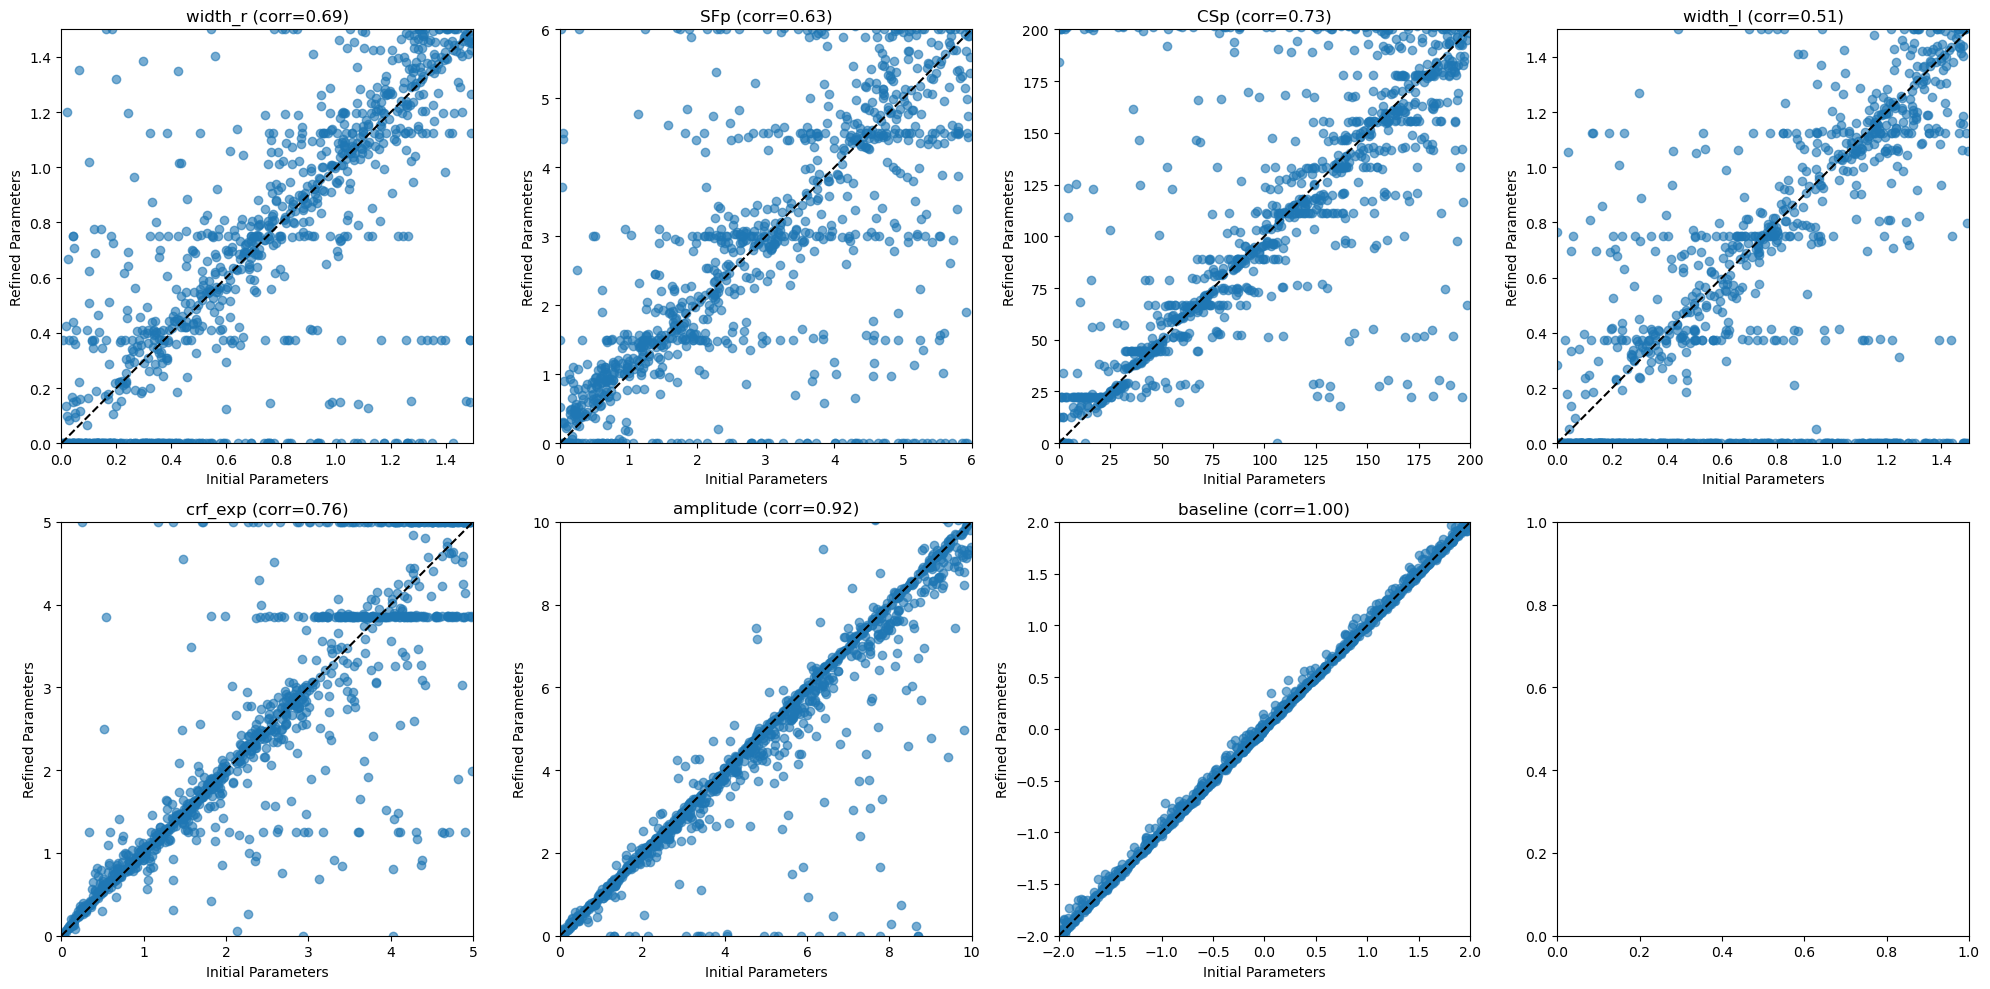

In [9]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
axs = axs.flatten()
param_names = parameters.columns

for i, param in enumerate(param_names):
    ax = axs[i]
    ax.scatter(
        parameters[param], 
        refined_pars[param], 
        # c=idx_cols, 
        alpha=0.6)
    corr = np.corrcoef(parameters[param], refined_pars[param])[0, 1]
    ax.set_title(f'{param} (corr={corr:.2f})')
    ax.set_xlabel('Initial Parameters')
    ax.set_ylabel('Refined Parameters')
    ax.plot([bounds[param][0], bounds[param][1]], 
            [bounds[param][0], bounds[param][1]], 'k--')
    ax.set_xlim(bounds[param])
    ax.set_ylim(bounds[param])
    # ax.set_aspect('square')

plt.tight_layout()
plt.show()

In [128]:
bfitter = BPRF(model, data)
# bfitter.add_priors_from_bounds(
#     bounds, 
# )
# bfitter.add_bijector_from_bounds(
#     bounds
# )
# for p in bfitter.model_labels:
#     if p == 'baseline':
#         continue
#     bfitter.add_bijector(
#         p, bijector_type='softplus',
#     )
# bfitter.prep_for_fitting()
bfitter.add_bijector(
    'amplitude', tfp.bijectors.Exp() 
)

init_pars = {
    'width_r' : np.ones(n_vx) * 1,
    'SFp' : np.ones(n_vx) * 6,
    'CSp' : np.ones(n_vx) * 100,
    'width_l' : np.ones(n_vx) * 0.68,
    'crf_exp' : np.ones(n_vx) * 1,
    'amplitude' : np.ones(n_vx) * 1, 
    'baseline' : np.ones(n_vx) * 0, 
}
init_pars = pd.DataFrame(init_pars)

bfitter.fit_mcmc(
    idx=[1,],
    init_pars=init_pars,
    # fixed_pars={'width_l':0.68},
    num_steps=50,
    # burnin=50, 
    # unrolled_leapfrog_steps=1,
    step_size=1,
    # max_tree_depth=5,
    sampler_fn='NUTS'
)

Lets run some checks with everything...
tf.Tensor(-625.1052, shape=(), dtype=float32)
Using tape.gradient to check gradients w/respect to each parameter
Gradient for parameter 0: [-5.020289]
Gradient for parameter 1: [-0.54644144]
Gradient for parameter 2: [0.22861685]
Gradient for parameter 3: [-25.327816]
Gradient for parameter 4: [11.138977]
Gradient for parameter 5: [109.16367]
Gradient for parameter 6: [421.89462]
initial_ll=-625.105224609375
Starting NUTS sampling...


In [107]:
bfitter.mcmc_stats.keys()
# bfitter.mcmc_stats['leapfrogs_taken']



dict_keys(['log_prob', 'is_accepted', 'accept_ratio', 'step_size', 'elapsed_time'])

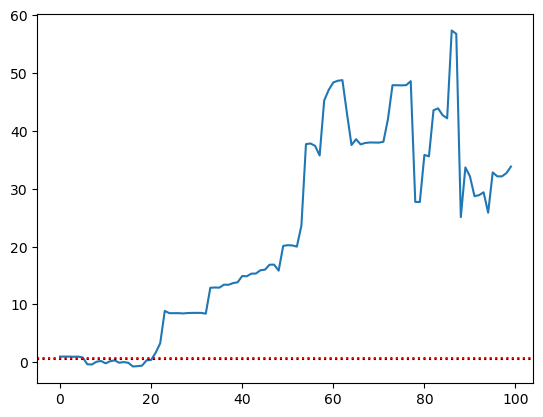

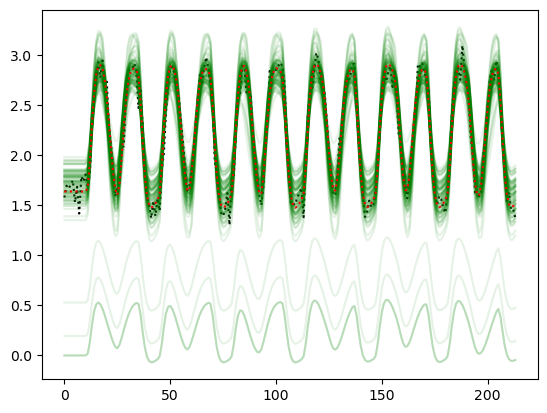

In [129]:
idx = 1
p = 'width_r'
plt.plot(
    bfitter.mcmc_sampler[idx][p]
)
plt.axhline(parameters[p][idx], linestyle=':', color='k')
plt.axhline(refined_pars[p][idx] , linestyle=':', color='r')

plt.figure()
plt.plot(data.iloc[:,idx], ':k')
preds = bfitter.get_predictions(parameters=bfitter.mcmc_sampler[idx])
plt.plot(preds, alpha=0.1, color='g')
cpreds = model.predict(parameters=refined_pars)
plt.plot(cpreds.iloc[:,idx], ':r')

In [75]:
bfitter.mcmc_sampler[idx][p]

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
545   NaN
546   NaN
547   NaN
548   NaN
549   NaN
Name: CSp, Length: 550, dtype: float32

In [ ]:
idx = 1
rsq = bfitter.get_rsq_for_idx(
    idx=idx, 
    parameters=bfitter.mcmc_sampler[idx]

)
plt.plot(rsq)

In [ ]:
# Lets see are we getting closer?
fig,axs = plt.subplots(2,4,figsize=(20,10))
axs = axs.flatten()
idx = 10
for ip,p in enumerate(bfitter.model_labels):
    ax = axs[ip]
    ax.set_title(p)
    ax.set_xlabel('Step in MCMC chain')
    # for i in range(10):

    ax.plot(
        bfitter.mcmc_sampler[idx][p],# - parameters[p][idx],
        color=idx_cols[idx],        
        )
    # Lets add the ground truth
    ax.axhline(
        parameters[p][idx], 
        color=idx_cols[idx],        
        linestyle=':'
    )

# ax = axs[-1]
# ax.set_title('Rsq')
# for i in range(10):
#     rsq = bfitter.get_rsq_for_idx(
#         idx=i, parameters=bfitter.mcmc_sampler[i],
#     )
#     plt.plot(
#         rsq, 
#         color=idx_cols[i]
#         ) 
# plt.ylim(0,1)
# plt.tight_layout()

In [ ]:
step_sizes = [.00001,  0.001, 0.005, 0.01, 0.05]
unrolled_steps = [1, 2, 3]
tree_depths = [5, 10, 15]

for step_size in step_sizes:
    for unroll in unrolled_steps:
        for depth in tree_depths:
            print(f"\nTrying step_size={step_size}, unrolled_steps={unroll}, tree_depth={depth}")
            try:
                bfitter.fit_all(
                    init_pars=init_pars,
                    num_steps=10,
                    burnin=10, 
                    unrolled_leapfrog_steps=unroll,
                    step_size=step_size,
                    max_tree_depth=depth
                )
            except Exception as e:
                print(f"Failed with error: {e}")
            plt.figure()
            rsq = []
            for idx in range(bfitter.n_voxels):
                rsq.append(bfitter.get_rsq_for_idx(idx=idx, parameters=bfitter.mcmc_sampler[idx]).T)
            plt.plot(np.array(rsq).T)
            plt.title(
                f"\nTrying step_size={step_size}, unrolled_steps={unroll}, tree_depth={depth}"
            )
        bloop





In [ ]:
idx = 10


In [ ]:
bfitter.mcmc_sampler[idx]

In [ ]:
idx = 1
burn_in = 100
plt.plot(cfitter.data.iloc[:,idx], ':k')
cpred = model.predict(parameters=refined_pars)
plt.plot(cpred.iloc[:,idx], 'b')
plt.text(
    x=1, y=0.9,  # Using axes coordinates (0-1 range)
    s=f"TRUTH {idx}:\n{parameters.iloc[idx,:].apply(lambda x: f'{x:.3f}').to_string()}",
    transform=plt.gca().transAxes,  # Use axes coordinates
    fontdict={'family': 'monospace', 'size': 8}
)
plt.text(
    x=1.3, y=0.9,  # Using axes coordinates (0-1 range)
    s=f"FIT {idx}:\n{refined_pars.iloc[idx,:].apply(lambda x: f'{x:.3f}').to_string()}",
    transform=plt.gca().transAxes,  # Use axes coordinates
    fontdict={'family': 'monospace', 'size': 8}
)
# this_pred = bfitter.model.predict(
#     parameters=bfitter.mcmc_sampler[idx]
# )
# plt.plot(
#     this_pred.iloc[:,burn_in:], '-g', alpha=.1,
# )

In [ ]:
idx = 500
pred = bfitter.get_predictions(
    parameters=bfitter.mcmc_sampler[idx],
    # c=rsq_cols[500:,:]
)
# colors = [tuple(color) for color in rsq_cols[id_start:, :-1]]
plt.plot(
    pred.iloc[:,burn_in:],
    # c=colors,
)
plt.plot(data.iloc[:,idx])


In [ ]:
idx = 0
burn_in = 100
sns_plot = sns.pairplot(
    fitter.mcmc_sampler[idx].iloc[burn_in:,:],
    plot_kws={'color':rsq_cols[burn_in:,:]},
    # corner=True, 
    diag_kind='kde'
)
sns_plot.map_lower(sns.kdeplot, levels=4, color=0.2)
# sns_plot.

edit_pair_plot(
    sns_plot.axes, 
    lines_dict=parameters.iloc[idx,:].to_dict(), 
    lim_dict=bounds, 
    color='g', linestyle=':', lw=4, label='Truth'
)
# edit_pair_plot(
#     sns_plot.axes, init_pars.iloc[idx,:].to_dict(), color='c', linestyle=':', lw=4,
# )
# edit_pair_plot(
#     sns_plot.axes, refined_pars.iloc[idx,:].to_dict(), color='r', linestyle=':', lw=4,
# )
plt.legend()
plt.show()

In [ ]:
a = fitter.mcmc_sampler[1]
pred = model.predict(parameters=a.iloc[:1,:])

plt.plot(data.iloc[:,0])
plt.plot(pred)

In [ ]:
for p in a.keys():
    plt.figure()
    plt.plot(a[p])
    plt.title(p)

for p in a.keys():
    plt.figure()
    plt.hist(a[p])
    plt.title(p)    

In [24]:
fitter.mcmc_sampler[0]

In [ ]:
import corner as corner
_ = corner.corner(
    fitter.mcmc_sampler[1].iloc[500:,:],# truths=parameters.iloc[0,:].T
    # truths=parameters.iloc[1,:]
)
print(parameters.iloc[1,:])
# corner.overplot_points(
#     plt.gcf(), parameters.iloc[0,:],
# )

In [ ]:
pred = fitter.model.predict(
    parameters=fitter.mcmc_sampler[1].iloc[7483:7484,:]
)
pred.plot()
data.iloc[:,0].plot()

In [ ]:
fitter.mcmc_stats[1]['log_prob'].numpy().argmax()

In [ ]:
parameters.keys()
a.keys()

In [ ]:
parameters

In [ ]:
b = model.predict(parameters=a.iloc[:100,:])
plt.plot(b)
plt.plot(data.iloc[:,0], '--k')

In [ ]:
data.iloc[:,0]

In [ ]:
Code

In [ ]:
pars  = ols_pars.iloc[:,0].to_numpy()
pars = pars[np.newaxis,...]
model.predict(parameters = pars) #ols_pars.iloc[:,:0])

In [93]:
eg1 = a[0].numpy()
eg2 = a[1].numpy()

In [ ]:
plt.plot(eg1[:,0])
plt.plot(eg2[:,0])

In [ ]:
init_pars = model._get_parameters(ols_pars)
model._transform_parameters_backward(init_pars.values.astype(np.float32))
